# Allenamento baseline ResNet50 per Traslazione + Rotazione (Pose Estimation)

Questo notebook permette di:
1. **Import e Setup**
2. **Carica dataset LineMOD**
3. **Inizializza PoseEstimator** (ResNet-50 backbone)
4. **Training**
5. **Valutazione su test set**

## 1. Import e Setup

In [5]:
import sys
from pathlib import Path
import torch
from torch import optim
import yaml
from pathlib import Path
import random
import numpy as np
import pandas as pd
from tqdm import tqdm

# Importa il config per usare path e file in altre cartelle
sys.path.insert(0, str(Path.cwd().parent))  # Aggiungi parent al path
from config import Config
from models.pose_estimator_endtoend import PoseEstimator
from utils.losses import PoseLoss
from dataset.linemod_pose import create_pose_dataloaders
from utils.visualization import show_pose_samples, plot_training_validation_loss_from_csv, show_pose_samples_with_add, plot_add_per_class, plot_pinhole_error_per_class
from utils.training import train_pose_full
from utils.transforms import quaternion_to_rotation_matrix_batch
from utils.metrics import compute_add_batch_full_pose, load_all_models, load_models_info
from utils.validation import run_deep_pose_pipeline


## 2. Carica dataset LineMOD

In [6]:
# Carica i dataloader train, val e test
train_loader, val_loader, test_loader = create_pose_dataloaders(
    dataset_root=Config.LINEMOD_ROOT,
    batch_size=Config.POSE_BATCH_SIZE,
    crop_margin=Config.POSE_CROP_MARGIN,
    output_size=Config.POSE_IMAGE_SIZE,
    num_workers=Config.NUM_WORKERS
)

print(f"Train batches: {len(train_loader)} | Val batches: {len(val_loader)} | Test batches: {len(test_loader)}")

Train batches: 30 | Val batches: 8 | Test batches: 210


### 2.1 Visualizza immagini training set con info su rotazione

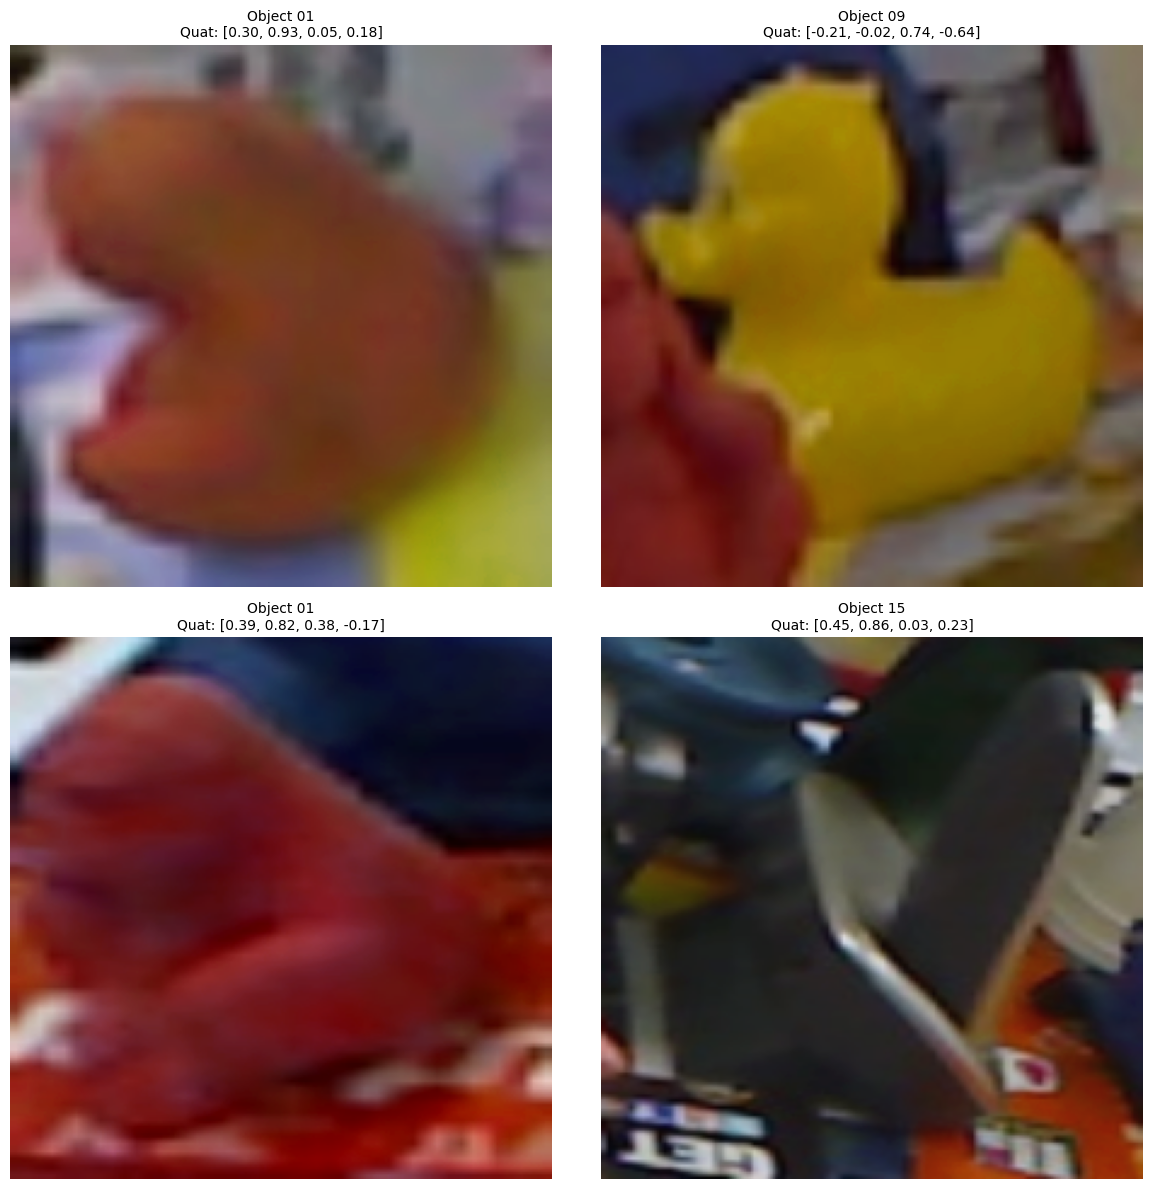

Visualizzazione sample del training set (immagini già croppate dal dataset)
Quaternion normalizzato (||q|| = 1)


In [7]:
# Visualizza alcuni sample del dataset (le immagini sono già croppate)
batch = next(iter(train_loader))
show_pose_samples(batch, n=4)

## 3. Inizializza Modello PoseEstimatorBaseline

In [8]:
# Inizializza il modello end-to-end per rotazione + traslazione (ResNet-50)
model = PoseEstimator(
    pretrained=True,
    dropout=Config.POSE_DROPOUT,
    freeze_backbone=False
    ).to(Config.DEVICE)

# Mostra info minimali sul modello
params_info = model.get_num_parameters()
print(f"Modello PoseEstimator caricato su: {Config.DEVICE}")
print(f"Parametri totali: {params_info['total']:,}")
print(f"Parametri allenabili: {params_info['trainable']:,}")

/Users/nicolotermine/Library/Caches/pypoetry/virtualenvs/polito-aml-6d-pose-estimation-LevBIKLF-py3.13/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/nicolotermine/Library/Caches/pypoetry/virtualenvs/polito-aml-6d-pose-estimation-LevBIKLF-py3.13/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


✅ PoseEstimator initialized
   Backbone: resnet50 (pretrained=True, frozen=False)
   Feature dim: 2048
   Output: 7 values (4 quaternion + 3 translation)
   Dropout: 0.5
Modello PoseEstimator caricato su: mps
Parametri totali: 26,137,671
Parametri allenabili: 26,137,671


## 4. Nome e path per allenare-caricare un modello

In [9]:
# Parametri utili anche quando non si fa training
NAME = "test_endtoend_pose_1"

checkpoint_dir = Config.CHECKPOINT_DIR / "pose" / NAME
checkpoint_weights_dir = checkpoint_dir / "weights"
best_path = checkpoint_weights_dir / "best.pt"
last_path = checkpoint_weights_dir / "last.pt"

## 5. Training (solo rotazione)

In [8]:
# Training end-to-end rotazione + traslazione (PoseLoss)
EPOCHS = 5 #Config.POSE_EPOCHS
LR = Config.POSE_LR
ACCUMULATION_STEPS = Config.ACCUMULATION_STEPS

# Salva args.yaml
args_dict = {
    'epochs': EPOCHS,
    'learning_rate': LR,
    'accumulation_steps': ACCUMULATION_STEPS,
    'batch_size': Config.POSE_BATCH_SIZE,
    'dropout': Config.POSE_DROPOUT,
    'freeze_backbone': False,
    'device': str(Config.DEVICE),
    'crop_margin': Config.POSE_CROP_MARGIN,
    'output_size': Config.POSE_IMAGE_SIZE,
    'weight_decay': Config.POSE_WEIGHT_DECAY
}
# Assicurati che la directory esista prima di salvare il file
checkpoint_dir.mkdir(parents=True, exist_ok=True)
with open(checkpoint_dir / "args.yaml", "w") as f:
    yaml.dump(args_dict, f)

criterion = PoseLoss()
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=Config.POSE_WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-7)

history, best_loss, best_epoch = train_pose_full(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=Config.DEVICE,
    epochs=EPOCHS,
    accumulation_steps=ACCUMULATION_STEPS,
    checkpoint_dir=str(checkpoint_dir),
    training_config=args_dict,
    save_best=True,
    save_last=True,
    verbose=True
)

print(f"\nBest loss: {best_loss:.4f} @ epoch {best_epoch+1}")
print("✅ Training completato!")

✅ PoseLoss initialized
   λ_trans: None
   λ_rot: None


Epoch 1/5: 100%|██████████| 30/30 [00:32<00:00,  1.08s/it, loss=923.2195, trans=174.0765, rot=1.06, lr_bb=1.00e-04, lr_hd=1.00e-04] 


Epoch 1: loss=1083.6430, val_loss=510.8089
💾 Best model salvato in: /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/pose/test_endtoend_pose_1/weights/best.pt


Epoch 2/5: 100%|██████████| 30/30 [00:32<00:00,  1.08s/it, loss=656.1114, trans=120.6755, rot=1.05, lr_bb=1.00e-04, lr_hd=1.00e-04]


Epoch 2: loss=794.5094, val_loss=417.7242
💾 Best model salvato in: /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/pose/test_endtoend_pose_1/weights/best.pt


Epoch 3/5: 100%|██████████| 30/30 [00:32<00:00,  1.07s/it, loss=577.8890, trans=104.0468, rot=1.15, lr_bb=1.00e-04, lr_hd=1.00e-04]


Epoch 3: loss=631.2020, val_loss=269.8022
💾 Best model salvato in: /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/pose/test_endtoend_pose_1/weights/best.pt


Epoch 4/5: 100%|██████████| 30/30 [00:32<00:00,  1.07s/it, loss=592.1675, trans=107.5450, rot=1.09, lr_bb=1.00e-04, lr_hd=1.00e-04]


Epoch 4: loss=550.7499, val_loss=375.4479
💾 Best model salvato in: /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/pose/test_endtoend_pose_1/weights/best.pt


Epoch 5/5: 100%|██████████| 30/30 [00:31<00:00,  1.06s/it, loss=545.0880, trans=98.1951, rot=1.08, lr_bb=1.00e-04, lr_hd=1.00e-04] 


Epoch 5: loss=498.5324, val_loss=168.3126
💾 Best model salvato in: /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/pose/test_endtoend_pose_1/weights/best.pt

Best loss: 498.5324 @ epoch 5
✅ Training completato!


### 5.1 Visualizzazione loss

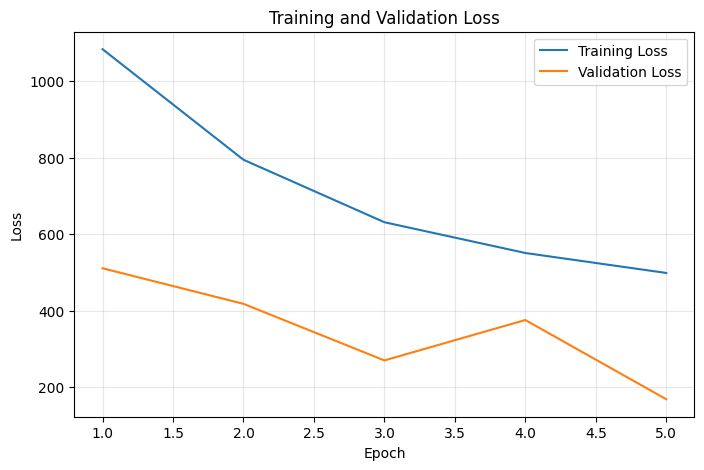

In [9]:
# Plotta la curva di training loss dal CSV
training_csv_path = checkpoint_dir / 'training_result.csv'
plot_training_validation_loss_from_csv(training_csv_path)

## 6. Test e Valutazione su sample del Test Set (solo rotazione)

### 6.1 Visualizza predizione su batch immagini

✅ Modello test_endtoend_pose_1 caricato e in modalità eval!
Batch casuale: estrazione batch random dal dataset di test
Indice di inizio batch casuale: 4371
Numero di sample estratti: 64
Chiavi batch: ['rgb_crop', 'quaternion', 'translation', 'cam_K', 'bbox', 'folder_id', 'sample_id', 'obj_id', 'depth_path', 'rgb_path', 'info_path']

Conversione quaternioni in matrici di rotazione
Carico odelli 3D degli oggetti in memoria. 
Questi vengono usati per calcolare la metrica ADD.
✅ Loaded model 01: 5841 points
✅ Loaded model 02: 38325 points
✅ Loaded model 04: 18995 points
✅ Loaded model 05: 22831 points
✅ Loaded model 06: 15736 points
✅ Loaded model 08: 12655 points
✅ Loaded model 09: 7912 points
✅ Loaded model 10: 18473 points
✅ Loaded model 11: 7479 points
✅ Loaded model 12: 15972 points
✅ Loaded model 13: 18216 points
✅ Loaded model 14: 27435 points
✅ Loaded model 15: 16559 points

Calcolo metrica ADD full pose
Test completato su 64 sample

📊 ADD medio sul batch:
   Mean ADD: 37.9295 ± 15

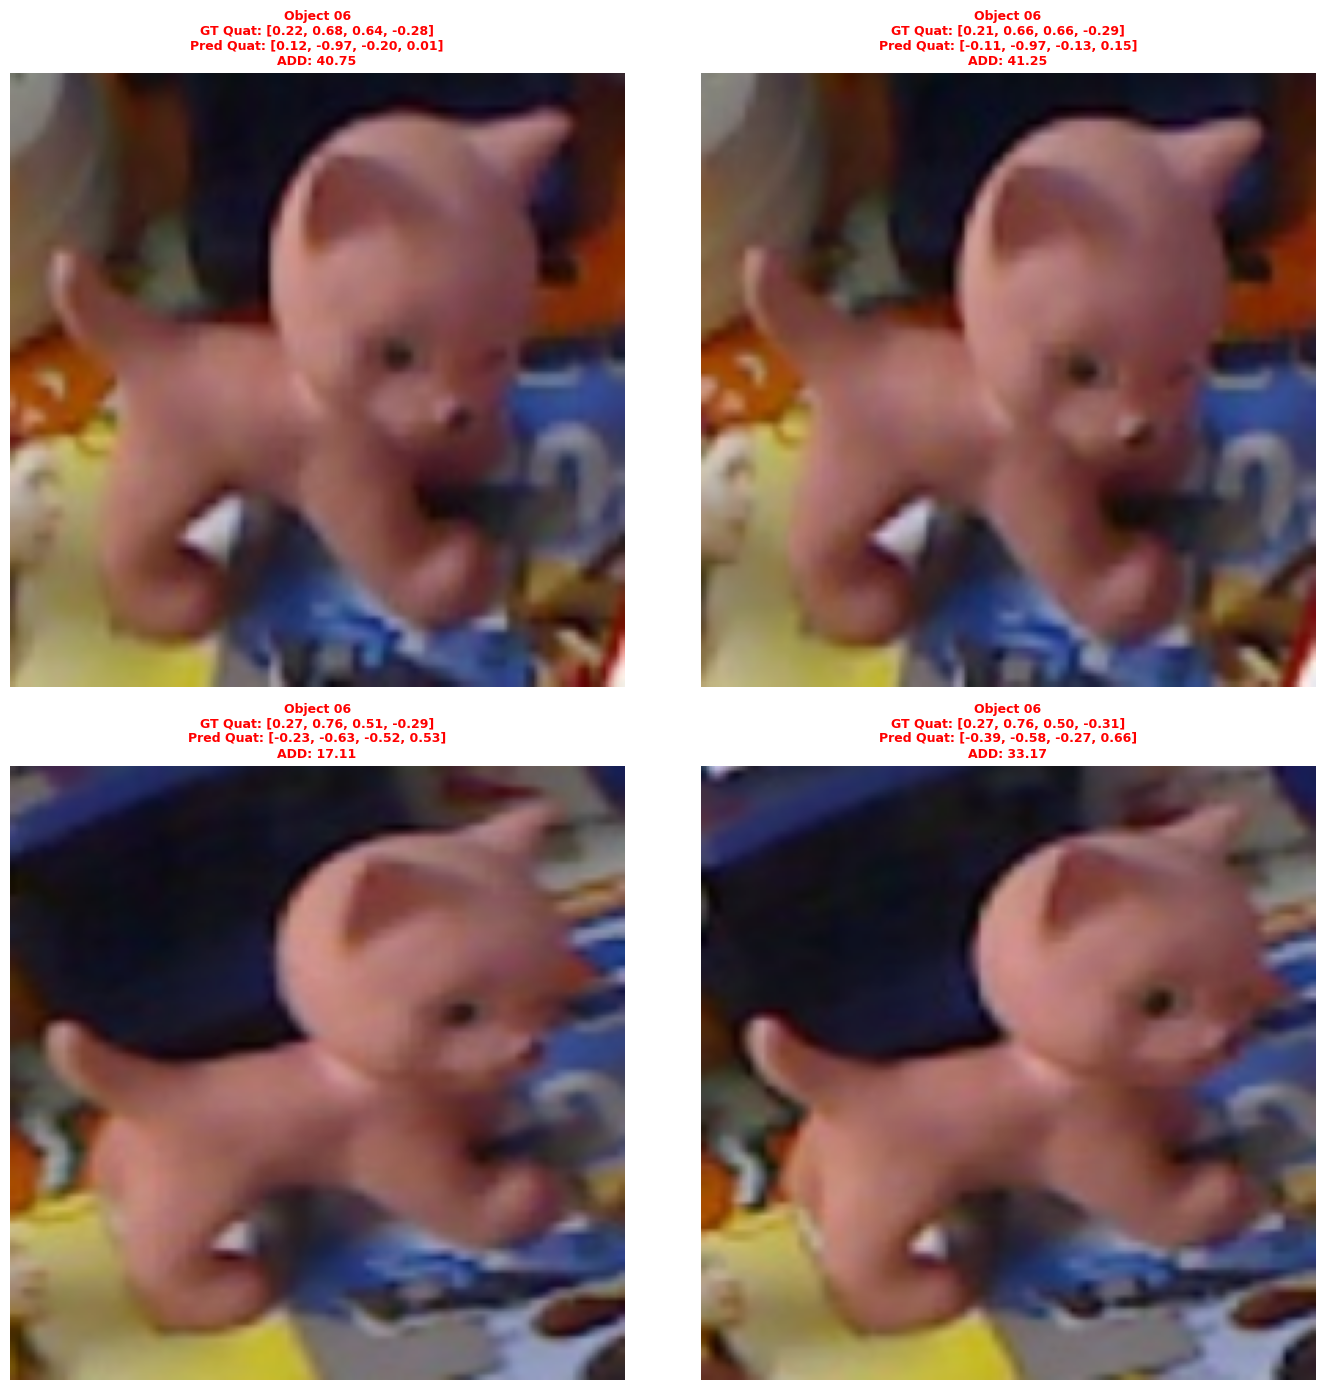

In [10]:
NAME = "test_endtoend_pose_1"
checkpoint_dir = Config.CHECKPOINT_DIR / "pose" / NAME
checkpoint_weights_dir = checkpoint_dir / "weights"
best_path = checkpoint_weights_dir / "best.pt"
last_path = checkpoint_weights_dir / "last.pt"

# Carica il modello trained (se necessario)
try:
    model.load_state_dict(torch.load(best_path, map_location=Config.DEVICE))
    model.eval()
    print(f"✅ Modello {NAME} caricato e in modalità eval!")
except Exception as e:
    print(f"⚠️  Modello non trovato o già caricato. Errore: {e}")
    raise SystemExit("Modello non trovato")

# Estrai un batch casuale direttamente dal dataset di test
print("Batch casuale: estrazione batch random dal dataset di test")
random_start = random.randint(0, len(test_loader.dataset) - test_loader.batch_size)
print(f"Indice di inizio batch casuale: {random_start}")
indices = list(range(random_start, random_start + test_loader.batch_size)) # lista indici selezionati
samples = [test_loader.dataset[i] for i in indices]
print(f"Numero di sample estratti: {len(samples)}")

# Collate i sample come fa il DataLoader
batch = {}
for k in samples[0]:
    values = [sample[k] for sample in samples]
    if isinstance(values[0], torch.Tensor):
        batch[k] = torch.stack(values)
    else:
        batch[k] = values
print(f"Chiavi batch: {list(batch.keys())}")
test_batch = batch

images = test_batch['rgb_crop'].to(Config.DEVICE)
gt_quaternions = test_batch['quaternion'].to(Config.DEVICE)
gt_translations = test_batch['translation'].to(Config.DEVICE) if 'translation' in test_batch else None
obj_ids = test_batch['obj_id']

with torch.no_grad():
    pred_quaternions, pred_translations = model(images)

# Conversione quaternioni in matrici di rotazione
print("\nConversione quaternioni in matrici di rotazione")
pred_R = quaternion_to_rotation_matrix_batch(pred_quaternions)
gt_R = quaternion_to_rotation_matrix_batch(gt_quaternions)

# Calcola la metrica ADD full pose (usa utils.metrics)
models_dict = load_all_models()
models_info = load_models_info(Config.LINEMOD_ROOT / "models" / "models_info.yml")

print("\nCalcolo metrica ADD full pose")
results = compute_add_batch_full_pose(pred_R, pred_translations.cpu().numpy(), gt_R, gt_translations.cpu().numpy(), obj_ids.cpu().numpy() if hasattr(obj_ids, 'cpu') else obj_ids, models_dict, models_info)

rot_trans_errors = results.get('add_values', None)
print(f"Test completato su {len(images)} sample")
print(f"\n📊 ADD medio sul batch:")
print(f"   Mean ADD: {np.mean(rot_trans_errors):.4f} ± {np.std(rot_trans_errors):.4f}")

# Visualizza 4 sample con errore di rotazione+traslazione
show_pose_samples_with_add(images, gt_quaternions, pred_quaternions, obj_ids, rot_trans_errors)

### 6.2 Statistiche su intero Test set

In [ ]:
# Valutazione deep-only (senza pinhole): salva risultati in CSV
run_deep_pose_pipeline(model, test_loader, name="test_endtoend_pose_1")

✅ Modello test_endtoend_pose_1 caricato e in modalità eval!
Carico odelli 3D degli oggetti in memoria. 
Questi vengono usati per calcolare la metrica ADD.
✅ Loaded model 01: 5841 points
✅ Loaded model 02: 38325 points
✅ Loaded model 04: 18995 points
✅ Loaded model 05: 22831 points
✅ Loaded model 06: 15736 points
✅ Loaded model 08: 12655 points
✅ Loaded model 09: 7912 points
✅ Loaded model 10: 18473 points
✅ Loaded model 11: 7479 points
✅ Loaded model 12: 15972 points
✅ Loaded model 13: 18216 points
✅ Loaded model 14: 27435 points
✅ Loaded model 15: 16559 points


Valutazione su test set: 100%|██████████| 210/210 [01:53<00:00,  1.84it/s]



concatenazione batch
conversione da quaternoni a matrici di rotazione
calcolo metriche: ADD full pose
✅ Risultati di validazione salvati in /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/pose/test_endtoend_pose_1/validation_result.csv


### 6.3 Tabella: Media ADD e Accuracy per Classe

La tabella seguente riporta la media dell'errore ADD e l'accuracy (percentuale di pose corrette) per ciascuna classe (oggetto) del dataset LineMOD.

In [11]:
# Carica risultati validazione dal CSV usando utils/validation.py
from utils.validation import load_validation_results
NAME = "test_endtoend_pose_1"
checkpoint_dir = Config.CHECKPOINT_DIR / "pose" / NAME
val_csv_path = checkpoint_dir / 'validation_result.csv'
if val_csv_path.exists():
    results_full_pose, _ = load_validation_results(val_csv_path)
    print(f"✅ Risultati caricati da {val_csv_path}")
else:
    results_full_pose = globals().get('results_full_pose', None)
    if results_full_pose is None:
        print("⚠️  Devi prima calcolare la metrica ADD full pose su tutto il test set e salvare i risultati in 'results_full_pose'.")

✅ Risultati caricati da /Users/nicolotermine/zMellow/GitHub-Poli/Polito/polito-aml-6D_pose_estimation/checkpoints/pose/test_endtoend_pose_1/validation_result.csv


In [12]:
# Tabella: Performance rotazione + traslazione (ADD full pose) usando utils/validation.py
from utils.validation import calc_add_accuracy_per_class
if results_full_pose is not None:
    data, global_add, global_acc = calc_add_accuracy_per_class(results_full_pose, Config.LINEMOD_OBJECTS)
    df = pd.DataFrame(data)
    display(df)
    print("\nMedia globale ADD (full pose):", f"{global_add:.2f}")
    print("Accuracy globale (full pose) (%):", f"{global_acc:.1f}")

,Classe,Media ADD (rot-only),Accuracy (%)
0,01 - ape,38.72,1.2
1,02 - benchvise,77.25,2.5
2,04 - camera,77.50,0.7
3,05 - can,71.96,0.7
4,06 - cat,50.78,2.7
5,08 - driller,28.15,42.5
6,09 - duck,48.61,0.6
7,10 - eggbox,71.26,0.9
8,11 - glue,46.08,4.8
9,12 - holepuncher,57.86,0.8



Media globale ADD (full pose): 62.72
Accuracy globale (full pose) (%): 4.5


### 6.4 Grafico: Media ADD per Classe

Il grafico seguente mostra la media dell'errore ADD per ciascuna classe, per un confronto visivo immediato delle performance del modello sui diversi oggetti.

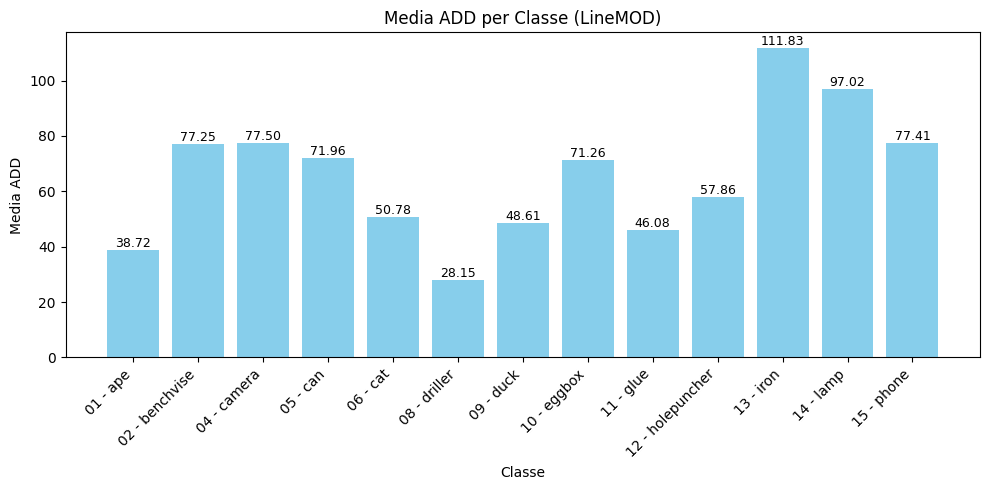

In [13]:
# Grafico a barre delle medie ADD per classe (full pose)
results_full_pose = globals().get('results_full_pose', None)
if results_full_pose is None:
    print("⚠️  Devi prima calcolare la metrica ADD full pose su tutto il test set e salvare i risultati in 'results_full_pose'.")
else:
    plot_add_per_class(results_full_pose, Config.LINEMOD_OBJECTS)